## Pre Explanation (msg to my mentor)

Additional explanation for the process I took:
1. grouped city to ‘others’  if their value percentage is not in the top 10. 
2. used dummy encoder to encode ‘city'
3. train model with original dataset
4. train model with oversampled dataset and 5 time cv (only oversample the train_fold)
5. compare the result and picked up two models with the most acceptable score: GaussianNB and LogisticRegression
6. train  GaussianNB and LogisticRegression with 5 cv and oversampling data and test the result on final test dataset: X_test, y_test.
7. plot lift curve and histogram of 'predicted probability’  vs 'y_test labels’ —— from the lift curve we can see LogisticRegression is doing slightly better than GaussianNB
8. get the model test score for the two models. 
9. sort the predicted probability and see how much positive labels we can capture within the top 20%, top50% of the predicted result, compare the result between GaussianNB and LogisticRegression —— confirmed result from 7 
10. As from step9 I can see model logisticRegression is doing better than GaussianNB so the next step I will do hyper parameters tuning with logisticRegression.

## Imports & Setup

In [110]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [111]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone
/Users/liuyang/Desktop/Springboard_Capstone


In [112]:
df = pd.read_csv('data/train.csv')

In [113]:
df.shape

(18359, 14)

In [114]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


## Count of unique values

In [115]:
# creata a function to calculate unique value count and percentage for the whole dataset
# and check the data type for each column
def data_info(data):
    count = data.nunique()
    va_pct = round(count/(data.shape[0])*100,2)
    nan_p = round(data.isnull().sum()/data.shape[0]*100,2)
    frame = pd.DataFrame(zip(count,va_pct,nan_p), index=count.index, 
                         columns=['counts','unique_value_pct', 'nan_pct']).reset_index().rename(columns={'index': 'column'})
    
  
    frame['data_type']= df.dtypes.tolist()
    return frame

In [116]:
data_info(df).sort_values('counts', ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.00,int64
12,training_hours,241,1.31,0.00,int64
1,city,123,0.67,0.00,object
2,city_development_index,93,0.51,0.00,float64
8,experience,22,0.12,0.32,object
9,company_size,8,0.04,26.03,object
7,major_discipline,6,0.03,15.46,object
10,company_type,6,0.03,27.45,object
11,last_new_job,6,0.03,2.00,object
6,education_level,5,0.03,2.49,object


## Range of values per column

In [117]:
# This only contains numerical variables.
df.agg([min,max]).T

,min,max
enrollee_id,1,33380
city,city_1,city_99
city_development_index,0.448,0.949
relevent_experience,Has relevent experience,No relevent experience
training_hours,1,336
target,0,1


In [118]:
# This only contains numerical variables.
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,18359.000000,18359.000000,18359.000000,18359.000000
mean,16729.360096,0.847140,65.899014,0.132088
std,9643.749725,0.110189,60.885300,0.338595
min,1.000000,0.448000,1.000000,0.000000
25%,8378.500000,0.796000,23.000000,0.000000
50%,16706.000000,0.910000,47.000000,0.000000
75%,25148.500000,0.920000,89.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


## Detecting missing values

In [119]:
data_info(df)[data_info(df).nan_pct !=0].sort_values('nan_pct', ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
10,company_type,6,0.03,27.45,object
9,company_size,8,0.04,26.03,object
3,gender,3,0.02,22.32,object
7,major_discipline,6,0.03,15.46,object
6,education_level,5,0.03,2.49,object
11,last_new_job,6,0.03,2.00,object
5,enrolled_university,3,0.02,1.86,object
8,experience,22,0.12,0.32,object


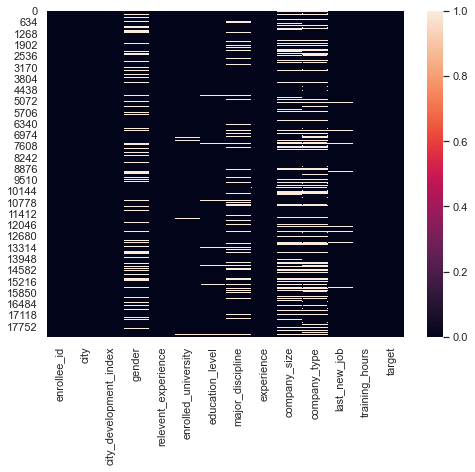

In [120]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=True)
plt.show()

## Data inspection and data grouping (without filling NaN value)

Check the details of values within each colum/variable:
what are the unique values and their percentage, and detecting incorrect input
<br>Group some of the values in categorical varaibles

In [121]:
# create a function to check the value_counts and value_counts ratio/pct for each variable 
def var_pct(data, column):
    count = data.value_counts(dropna=False)
    pct = round(count/(data.shape[0])*100,2)
    frame = pd.DataFrame(zip(count,pct), index=count.index, 
                         columns=['counts','pct']).reset_index().rename(columns={'index': column})
    
    return frame.sort_values('pct',ascending=False)

   label  counts    pct
0      0   15934  86.79
1      1    2425  13.21


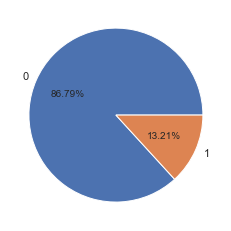

In [122]:
# Call function var_pct() on column 'target', enrollee who is open to a new employment is labeled as 1
# label 1 is also considered as 'target' in this dataset, label 0 is considered as 'non-target'
print(var_pct(df['target'], 'label'))

# Let's check the percentage in a pie graph, we can see the ratio of value 1 and 0 is about 1:6. 
df_target = var_pct(df['target'], 'label')
plt.pie(df_target.counts, labels= df_target.label, autopct='%.2f%%')
plt.show()


We can see the data is imbalanced. The ratio of the positive class (1) and negative class (0) is about 1:6

In [123]:
# check the value_counts pct for top 10 cities.
var_pct(df.city,'city').nlargest(10,'pct')

,city,counts,pct
0,city_103,4358,23.74
1,city_21,1672,9.11
2,city_16,1654,9.01
3,city_114,1472,8.02
4,city_160,827,4.50
5,city_136,624,3.40
6,city_67,455,2.48
7,city_75,332,1.81
8,city_104,318,1.73
9,city_102,313,1.70


In [124]:
# if the city's value_count ratio is lower than 1.7 then group them to 'Others'
df.city = df.city.map(lambda x: x.split('_')[1] if (df['city']==x).sum()/df.shape[0]*100 >= 1.7
                      else 'others').astype('str')

In [148]:
var_pct(df.company_size, 'company_size')

,company_size,counts,pct
0,1.0,7866,42.85
1,3.0,5623,30.63
2,2.0,4870,26.53


In [126]:
# we can see value '10/49' should be '10-49', value '100-500' should be '100-499'
df.company_size = df.company_size.map(lambda x: '1' if x in ['<10','10/49','50-99'] 
                                      else '2' if x in['100-500', '500-999'] 
                                      else '3' if x in ['1000-4999', '5000-9999', '10000+']
                                      else None)

In [127]:
var_pct(df.experience, 'experience')

,experience,counts,pct
0,>20,3437,18.72
1,5,1309,7.13
2,4,1250,6.81
3,3,1159,6.31
4,6,1125,6.13
5,2,992,5.40
6,9,979,5.33
7,10,967,5.27
8,7,950,5.17
9,8,755,4.11


In [128]:
df.experience = df.experience.map(lambda x: '0' if x == '<1'
                                  else '21' if x == '>20'
                                  else x if x is not None
                                  else None)

In [150]:
var_pct(df.major_discipline, 'major')

,major,counts,pct
0,1.0,16243,88.47
1,0.0,2116,11.53


In [130]:
df.major_discipline = df.major_discipline.map(lambda x: '1' if x == 'STEM' 
                                              else '0' if x in ['Humanities','Other','Business Degree', 'Arts', 'No Major']
                                              else None )

In [131]:
var_pct(df.last_new_job, 'last new job')

,last new job,counts,pct
0,1,7567,41.22
1,>4,3339,18.19
2,2,2835,15.44
3,never,2186,11.91
4,4,1038,5.65
5,3,1027,5.59
6,NaN,367,2.00


In [132]:
df.last_new_job = df.last_new_job.map(lambda x: '0' if x == 'never' 
                                      else '5' if x == '>4'
                                      else x if x is not None
                                      else None)

In [149]:
var_pct(df.company_type, 'company type')

,company type,counts,pct
0,3.0,13935,75.90
1,2.0,2293,12.49
2,1.0,2131,11.61


In [134]:
df.company_type = df.company_type.map(lambda x: '1' if x in ['Funded Startup', 'Early Stage Startup'] 
                                      else '2' if x in ['Public Sector', 'NGO', 'Other']
                                      else '3' if x == 'Pvt Ltd'
                                      else None)

In [135]:
var_pct(df.relevent_experience, 'relevent experience')

,relevent experience,counts,pct
0,Has relevent experience,13596,74.06
1,No relevent experience,4763,25.94


In [136]:
df.relevent_experience = df.relevent_experience.map(lambda x: '0' if x=='No relevent experience'
                                                   else '1')

In [137]:
var_pct(df.enrolled_university, 'univeristy enrollment')

,univeristy enrollment,counts,pct
0,no_enrollment,13659,74.40
1,Full time course,3187,17.36
2,Part time course,1171,6.38
3,NaN,342,1.86


In [138]:
df.enrolled_university = df.enrolled_university .map(lambda x: '0' if x=='no_enrollment'
                                                    else '1' if x in ['Full time course', 'Part time course']
                                                    else None)

In [139]:
var_pct(df.education_level, 'education level')

,education level,counts,pct
0,Graduate,10769,58.66
1,Masters,4319,23.53
2,High School,2032,11.07
3,Phd,459,2.50
4,NaN,457,2.49
5,Primary School,323,1.76


In [140]:
df.education_level = df.education_level.map(lambda x: '1' if x in ['Primary School','High School']
                                           else '2' if x == 'Graduate'
                                           else '3' if x in ['Masters', 'Phd']
                                           else None)

In [141]:
df.gender = df.gender.map(lambda x: '1' if x == 'Male' 
                         else '2' if x == 'Female'
                         else '3' if x == 'Other'
                         else None)

In [142]:
data_info(df)[data_info(df).nan_pct !=0].sort_values('nan_pct', ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
10,company_type,3,0.02,27.45,object
9,company_size,3,0.02,26.03,object
3,gender,3,0.02,22.32,object
7,major_discipline,2,0.01,15.46,object
6,education_level,3,0.02,2.49,object
11,last_new_job,6,0.03,2.00,object
5,enrolled_university,2,0.01,1.86,object
8,experience,22,0.12,0.32,object


In [143]:
impute_list = data_info(df)[data_info(df).nan_pct !=0].column.tolist()
impute_list 

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

## Missing value imputation

Fill missing value with KNN imputer

In [144]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=1, weights="uniform")
df[impute_list] = imputer.fit_transform(df[impute_list]) 

In [36]:
# make sure there's no more missing values
data_info(df).sort_values('counts', ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.0,int64
12,training_hours,241,1.31,0.0,int64
2,city_development_index,93,0.51,0.0,float64
8,experience,22,0.12,0.0,float64
1,city,11,0.06,0.0,object
11,last_new_job,6,0.03,0.0,float64
3,gender,3,0.02,0.0,float64
6,education_level,3,0.02,0.0,float64
9,company_size,3,0.02,0.0,float64
10,company_type,3,0.02,0.0,float64


In [37]:
# We will not use enrolle_id as predictor, so drop this column from the dataset
df = df.drop('enrollee_id',axis=1)

In [38]:
# check the columns that are not float.
cat_col=data_info(df)[data_info(df).data_type=='object'].column.tolist()
int_col = data_info(df)[data_info(df).data_type=='int64'].column.tolist()
print("categorical list is:", cat_col)
print("int64 columns are: ", int_col)

categorical list is: ['city', 'relevent_experience']
int64 columns are:  ['training_hours', 'target']


In [39]:
# convert relevent_experience from object to float, and use dummy encoder to encode 'city' later.
df.relevent_experience = df.relevent_experience.astype('float')

In [40]:
# convert all the int64 to float data type. 
df[int_col] = df[int_col].astype('float')

In [41]:
data_info(df).sort_values('counts',ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
11,training_hours,241,1.31,0.0,float64
1,city_development_index,93,0.51,0.0,float64
7,experience,22,0.12,0.0,float64
0,city,11,0.06,0.0,object
10,last_new_job,6,0.03,0.0,float64
2,gender,3,0.02,0.0,float64
5,education_level,3,0.02,0.0,float64
8,company_size,3,0.02,0.0,float64
9,company_type,3,0.02,0.0,float64
3,relevent_experience,2,0.01,0.0,float64


In [42]:
# encode the last object column 'city' via dummy encoding
cat_col= data_info(df)[data_info(df).data_type=='object'].column.tolist()
df = pd.get_dummies(df,columns=cat_col)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_103,city_104,city_114,city_136,city_16,city_160,city_21,city_67,city_75,city_others
0,0.689,1.0,1.0,0.0,2.0,1.0,3.0,2.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.923,1.0,1.0,0.0,2.0,1.0,14.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.910,1.0,1.0,0.0,2.0,1.0,6.0,1.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,0.666,1.0,1.0,0.0,2.0,1.0,14.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,0.887,1.0,0.0,0.0,3.0,1.0,8.0,2.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
df.shape

(18359, 23)

In [147]:
var_pct(df.experience, 'experience')

,experience,counts,pct
0,21.0,3442,18.75
1,5.0,1310,7.14
2,4.0,1256,6.84
3,3.0,1176,6.41
4,6.0,1128,6.14
5,2.0,993,5.41
6,9.0,982,5.35
7,10.0,967,5.27
8,7.0,952,5.19
9,8.0,764,4.16


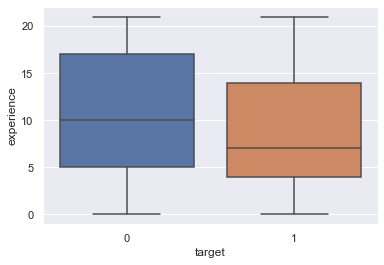

In [146]:
sns.boxplot(x='target', y='experience', data=df)

In [44]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,city_development_index,93,0.51,0.0,float64
1,gender,3,0.02,0.0,float64
2,relevent_experience,2,0.01,0.0,float64
3,enrolled_university,2,0.01,0.0,float64
4,education_level,3,0.02,0.0,float64
5,major_discipline,2,0.01,0.0,float64
6,experience,22,0.12,0.0,float64
7,company_size,3,0.02,0.0,float64
8,company_type,3,0.02,0.0,float64
9,last_new_job,6,0.03,0.0,float64


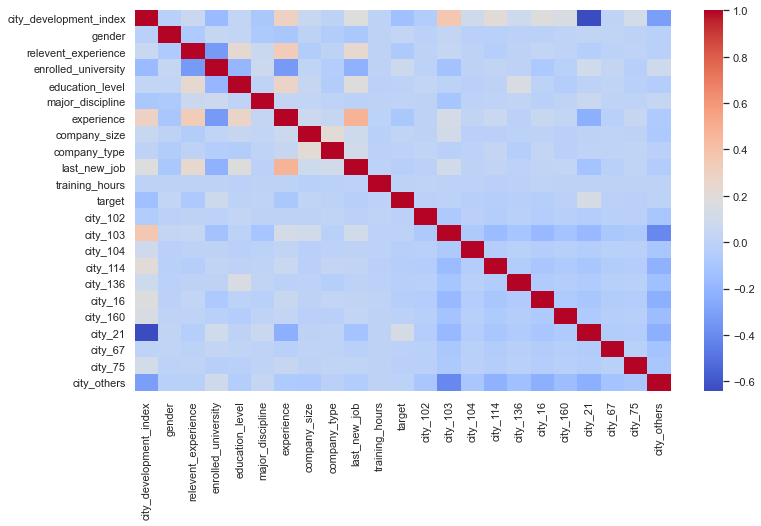

In [45]:
# check correlation between each variable
_= plt.subplots(figsize=(12,7))
sns.heatmap(df.corr(),cmap='coolwarm') 
plt.show()

X = df.drop('target',axis=1)
y = df['target'].ravel()

X.head()

X_scaled = StandardScaler().fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

# check target count in full, train, test dataset 
target_test_set = np.unique(y_test,return_counts=True)[1]
target_train_set = np.unique(y_train,return_counts=True)[1]
target_full_set= np.unique(df.target,return_counts=True)[1]

df_target = pd.DataFrame([target_full_set,target_train_set,target_test_set ], 
                         index=['Full Dataset', 'Training set', 'Testing set'], 
                         columns=['non-target count', 'target count'])

df_target['target %'] = round(df_target['target count']/df_target.sum(axis=1)*100,3)
df_target

# Check how imbalanced the data is in y_train.
np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1]

we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']

models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

# create a function to train model with n fold cv and return the result
def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    res = pd.DataFrame(model_res).round(3)
    return res

# create a function to return the test result for all models
def allmodel_perform(X, y, n, model_eval):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score by calling function model_eval()
    # (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(3)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

model_res = allmodel_perform(X_train, y_train, 5, model_eval)
model_res

# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,15))

axs[0].barh('model', 'test_recall', data=model_res)
axs[1].barh('model', 'test_f1_score', data=model_res)
axs[2].barh('model', 'test_accuracy', data=model_res)
axs[3].barh('model', 'test_roc_auc',data=model_res)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.3,0.3],[-1,9],'r--')
axs[1].plot([0.2,0.2],[-1,9],'r--')
axs[2].plot([0.8,0.8],[-1,9],'r--')
axs[3].plot([0.6,0.6],[-1,9],'r--')
plt.show()

# create function to train models with n fold cross validation and oversample data only on the train fold in each cross validation 
# and return test result of score precision, recall, f1score, auc, roc_auc
def model_eval_os(model_name, X, y, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train_fold, y_train_fold = X[train], y[train]
        X_test_fold, y_test_fold = X[test], y[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
     
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    
    return res

# call function allmodel_perform() to get the test for all models 
# using model_eval_os() function to get result after oversampling dataset

model_res_os = allmodel_perform(X_train, y_train, 5, model_eval_os)

model_res_os.sort_values('test_recall', ascending=False)

# create a function to train final model on oversampled data with n fold cross validation and return final model.
def trainmodel_os_cv(model, X, y, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X,y)):
        X_train_fold, y_train_fold = X[train], y[train]
        X_test_fold, y_test_fold = X[test], y[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model.fit(X_train_oversampled, y_train_oversampled)
    
    return model

# train model on oversampled data with n cross validation 
# then plot lift curve and 'predicted probability' vs 'label of test data' histogram based on model prediction 
# then return model score on test data 
import scikitplot as skplt 

def liftcurve_probahisto_score(model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # use function trainmodel_os_cv() to train model on oversampled X_train, y_train with n cv 
    final_model = trainmodel_os_cv(model, X_train, y_train, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    #predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    
#    sns.histplot(predProba_label, x='proba', hue='label', stat='probability', element='step',bins=10, ax=ax2)
#     ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r' , lw=2)
#     ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative', lw=2)
#     ax2.set_ylim([0,10.0])
    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

There's 728 positive datapoints(label=1) in y_test which contains 5508 datapoints.
<br>If we use LogisticRegression we can capture 264, 469 <b>label1</b> among the top 20%, top50% of the predicted result,
<br>meaning we can capture 36.3%, 64.4% of <b>label1</b> from the top20%,  top50% predicted result. (264/728=0.363)
<br>While using GaussianNB we can only capture 250, 449 label1 among the top 20%, top50% of the predicted result.
<br>meaning we can capture 34.3%,  61.7% of <b>label1</b> from the top20%, top50% predicted result.
<br>* Question 1: Therefore we should choose LogisticRegression as the final model?
<br>* Question 2: As my dataset contains both continuous variables and discrete variables, so I am no very sure if I can use GaussianNB classifier in this case


# get liftcurve, probahisto and scores on X_train, y_train for model LR

liftcurve_probahisto_score(LogisticRegression(), 'LogisticRegression', 5, X_train, y_train, 8, 0.3)

# get liftcurve, probahisto and scores on X_test, y_test for model LR
liftcurve_probahisto_score(LogisticRegression(), 'LogisticRegression', 5, X_test, y_test, 8, 0.3)

# get liftcurve, probahisto and scores on X_train, y_train for model GaussianNB
liftcurve_probahisto_score(GaussianNB(), 'GaussianNB',  5, X_train, y_train, 8, 0.35)

# get liftcurve, probahisto and scores on X_test, y_test for model GaussianNB
liftcurve_probahisto_score(GaussianNB(), 'GaussianNB', 5, X_test, y_test, 8, 0.35)

liftcurve_probahisto_score(KNeighborsClassifier(), 'KNN',  5, X_train, y_train, 8, 0.5)

liftcurve_probahisto_score(KNeighborsClassifier(), 'KNN',  5, X_test, y_test, 8, 0.5)

liftcurve_probahisto_score(DecisionTreeClassifier(random_state=43), 'DT', 5,  X_train, y_train, 8, 1.0)

liftcurve_probahisto_score(DecisionTreeClassifier(random_state=43), 'DT',  5, X_test, y_test, 8, 1.0)

liftcurve_probahisto_score(RandomForestClassifier(random_state=43), 'RF',  5, X_train, y_train, 8, 0.7)

liftcurve_probahisto_score(RandomForestClassifier(random_state=43), 'RF',  5, X_test, y_test, 8, 0.7)

liftcurve_probahisto_score(GradientBoostingClassifier(random_state=43), 'GB',  5, X_train, y_train, 8, 0.3)

liftcurve_probahisto_score(GradientBoostingClassifier(random_state=43), 'GB',  5, X_test, y_test, 8, 0.3)

liftcurve_probahisto_score(XGBClassifier(random_state=43), 'XGB',  5, X_train, y_train, 8, 0.5)

liftcurve_probahisto_score(XGBClassifier(random_state=43), 'XGB',  5, X_test, y_test, 8, 0.5)

liftcurve_probahisto_score(lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_train, y_train, 8, 0.4)

liftcurve_probahisto_score(lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_test, y_test, 8, 0.4)

liftcurve_probahisto_score(SVC(probability=True, random_state=43), 'SVC',  5,  X_train, y_train, 6, 0.3)

liftcurve_probahisto_score(SVC(probability=True, random_state=43), 'SVC',  5,  X_test, y_test, 6, 0.3)

## Check feature importance for model GaussianNB and LogisticRegression

# check feature importance for LogisticRegression
model = trainmodel_os_cv(LogisticRegression(), X_train, y_train, 5)
len(model.coef_[0])

fig,ax = plt.subplots(figsize=(16,10))
    
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(model.coef_[0]))

# check feature importance for GaussianNB
from sklearn.inspection import permutation_importance
model = trainmodel_os_cv(GaussianNB(), X_train, y_train, 5)

imps = permutation_importance(model, X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(imps.importances_mean))
plt.show()

model = trainmodel_os_cv(GradientBoostingClassifier(random_state=43), X_train, y_train, 5)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

# feature importance for lighgbm
from lightgbm import plot_importance
model = trainmodel_os_cv(lgb.LGBMClassifier(objective='binary',random_state=43), X_train, y_train, 5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

# feature importance for XGB
from xgboost import plot_importance
model = trainmodel_os_cv(XGBClassifier(random_state=43), X_train, y_train, 5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

model = trainmodel_os_cv(XGBClassifier(random_state=43), X_train, y_train, 5)


y_probas = model.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas)


from __future__ import absolute_import
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer as load_data
import scikitplot as skplt


X, y = load_data(return_X_y=True)
lr = LogisticRegression()
lr.fit(X, y)
probas = lr.predict_proba(X)
skplt.metrics.plot_lift_curve(y_true=y, y_probas=probas)
plt.show()

y.shape